In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm


In [46]:
def bermudan_option_binomial(S0, K, T, r, sigma, N, exercise_dates, option_type="call"):
    """
    Price a Bermudan option using the Binomial Tree method.
    
    Parameters:
    - S0: Initial stock price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate
    - sigma: Volatility of the underlying asset
    - N: Number of steps in the binomial tree
    - exercise_dates: List of times (as fractions of T) at which early exercise is allowed
    - option_type: "call" for call option, "put" for put option
    
    Returns:
    - The option price
    """
    
    # Calculate parameters for binomial tree
    dt = T / N  # Time increment
    u = np.exp(sigma * np.sqrt(dt))  # Up factor
    d = 1 / u  # Down factor
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability
    
    # Initialize asset prices at maturity
    stock_prices = np.zeros(N + 1)
    stock_prices[0] = S0 * d**N
    for i in range(1, N + 1):
        stock_prices[i] = stock_prices[i - 1] * u / d

    # Initialize option values at maturity
    option_values = np.maximum(0, (stock_prices - K) if option_type == "call" else (K - stock_prices))
    #print(option_values, stock_prices)
    
    # Backward induction for Bermudan option pricing
    for i in range(N - 1, -1, -1):
        stock_prices = stock_prices[:-1] * u  # Step back in time
        option_values = np.exp(-r * dt) * (p * option_values[1:] + (1 - p) * option_values[:-1])
        
        # Apply early exercise at specified exercise dates
        if i * dt in exercise_dates:
            #print(f"Applying early exercise at time {i * dt}")
            exercise_values = np.maximum(0, (stock_prices - K) if option_type == "call" else (K - stock_prices))
            #print(exercise_values, stock_prices, K)
            option_values = np.maximum(option_values, exercise_values)

    return option_values[0]


In [64]:
def blackScholes(current_stock_price, strike_price, current_time, maturity_time, interest_rate, volatality, option_type = "put"):
    """
    Function to calculate the price of the option using Black Scholes model

    Args:
        current_stock_price : Current stock price
        strike_price : Strike price
        current_time : Current time
        maturity_time : Maturity time
        interest_rate :  Risk free interest rate
        volatality : Volatality of the stock

    Returns:
        Option_price : Price of the option at current time
        delta : Delta value of the option
    """
    
    tao = maturity_time - current_time
    d1 = (np.log(current_stock_price/strike_price) + (interest_rate + volatality**2/2) * tao)/(volatality*np.sqrt(tao))
    d2 = d1 - volatality * np.sqrt(tao)
    if option_type == "put":
        option_price =  - current_stock_price * norm.cdf(-d1) + np.exp(-interest_rate * tao) * strike_price * norm.cdf(-d2)
        delta = - norm.cdf(-d1)
    else:
        option_price = current_stock_price * norm.cdf(d1) - np.exp(-interest_rate * tao) * strike_price * norm.cdf(d2)
        delta = norm.cdf(d1)
    
    
    return option_price

In [29]:
blackScholes(100, 90, current_time = 0, maturity_time = 1, interest_rate = 0.05, volatality = 0.2, option_type = "call")

(16.699448408416004, 0.8097030607754923)

In [36]:
bermudan_option_binomial(100, 90, 1, 0.05, 0.2, 4, list(np.arange(1/4, 1.01, 1/4)), option_type="call")

[ 0.          0.4837418  20.51709181 44.98588076]
[ 0.         10.         32.14027582]
[ 0.4837418  20.51709181]


17.02832551053355

### Convergence of Bermudan Option Price

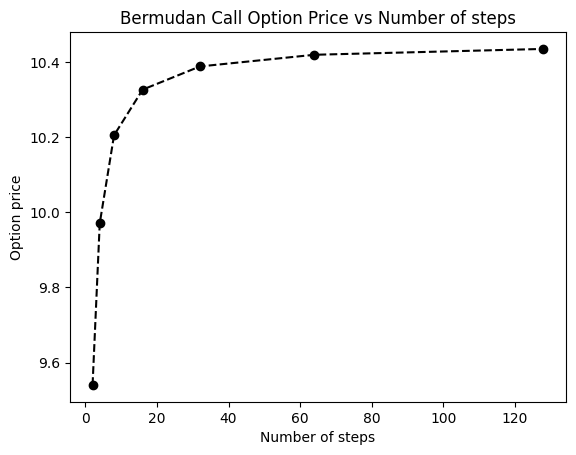

In [68]:
exercise_dates = list(np.arange(1/128, 1.01, 1/128))
num_steps = [2**i for i in range(1, 8)]
S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.2

bermudan_option_prices = [bermudan_option_binomial(S0, K, T, r, sigma, n_steps, exercise_dates, option_type="call") for n_steps in num_steps]
blackScholes_option_price = blackScholes(S0, K, current_time = 0, maturity_time = 1, interest_rate = 0.05, volatality = 0.2, option_type = "call")
error = [abs(blackScholes_option_price - price) for price in bermudan_option_prices]
plt.plot(num_steps, bermudan_option_prices, label="Bermudan Option", marker="o", color = "k", linestyle = "--")
plt.xlabel("Number of steps")
plt.ylabel("Option price")
plt.title("Bermudan Call Option Price vs Number of steps")
plt.savefig("bermudan_option.png")
plt.show()


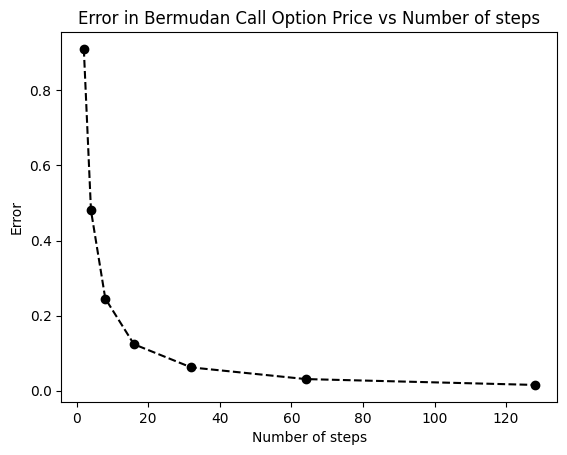

In [69]:
plt.plot(num_steps, error, label="Error", marker="o", color = "k", linestyle = "--")
plt.xlabel("Number of steps")
plt.ylabel("Error")
plt.title("Error in Bermudan Call Option Price vs Number of steps")
plt.savefig("bermudan_option_error.png")
plt.show()

### Increase Number of Exercise Points

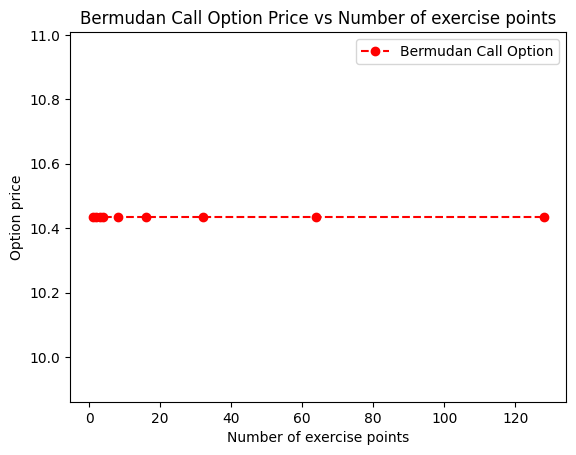

In [70]:
Exercise_points = [[1.0], [1, 0.75], [0.5, 0.75, 1.0], [0.25, 0.5, 0.75, 1.0], list(np.arange(1/8, 1.01, 1/8)), list(np.arange(1/16, 1.01, 1/16)), list(np.arange(1/32, 1.01, 1/32)), list(np.arange(1/64, 1.01, 1/64)), list(np.arange(1/128, 1.01, 1/128))]
ber_option_prices = [bermudan_option_binomial(S0, K, T, r, sigma, 128, exercise_dates, option_type="call") for exercise_dates in Exercise_points]
plt.plot([1, 2, 3, 4, 8, 16, 32, 64, 128], ber_option_prices, label="Bermudan Call Option", marker='o', linestyle='--', color='r')
plt.xlabel("Number of exercise points")
plt.ylabel("Option price")
plt.legend()
plt.title("Bermudan Call Option Price vs Number of exercise points")
plt.savefig("bermudan_option_call.png")
plt.show()

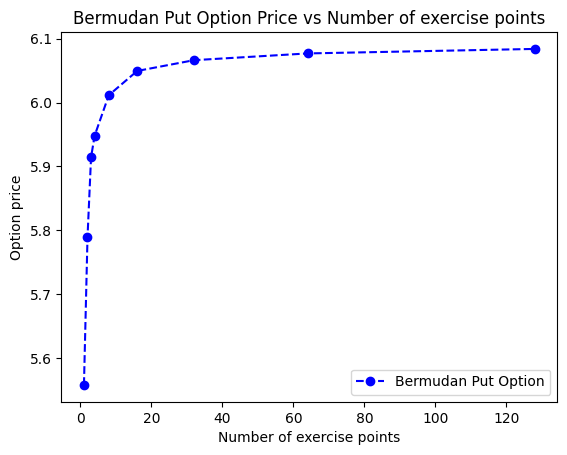

In [71]:
Exercise_points = [[1.0], [1, 0.75], [0.5, 0.75, 1.0], [0.25, 0.5, 0.75, 1.0], list(np.arange(1/8, 1.01, 1/8)), list(np.arange(1/16, 1.01, 1/16)), list(np.arange(1/32, 1.01, 1/32)), list(np.arange(1/64, 1.01, 1/64)), list(np.arange(1/128, 1.01, 1/128))]
ber_option_prices = [bermudan_option_binomial(S0, K, T, r, sigma, 128, exercise_dates, option_type="put") for exercise_dates in Exercise_points]
plt.plot([1, 2, 3, 4, 8, 16, 32, 64, 128], ber_option_prices, label="Bermudan Put Option", marker='o', linestyle='--', color='b')
plt.xlabel("Number of exercise points")
plt.ylabel("Option price")
plt.legend()
plt.title("Bermudan Put Option Price vs Number of exercise points")
plt.savefig("bermudan_option_put.png")
plt.show()